In [318]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Paramètres

In [319]:
# Valeurs physiques
gamma = 72e-3; # Tension superficielle eau-air (en N/m)
theta_hydrophobe = 120; # Angle de contact eau-PDMS (en degrés) pré-plasmatisation https://pmc.ncbi.nlm.nih.gov/articles/PMC2967237/ 
theta_hydrophile = 60; # Angle de contact eau-PDMS (en degrés) post-plasmatisation https://pmc.ncbi.nlm.nih.gov/articles/PMC2967237/ 
rho = 1e3; # Masse volumique de l'eau (en kg/m^3)
eta = 1e-3; # Viscosité dynamique de l'eau (en Pa.s)
g = 9.81; # Accélération gravitationnelle (en m/s^2)

# Dimensions géométriques 
h_puce = 2.75e-3; # Épaisseur de la puce (en m)

d_inlet = 2.9e-3; # Diamètre interne de l'inlet (en m)
d_raman = 2e-3; # Diamètre interne du trou Raman (en m)
d_outlet = 1.5e-3 # Diamètre interne de l'outlet (en m)
d_bille = 350e-6; # Diamètre des billes (en m)

L_puits = 700e-6 # Longueur du puits (en m)
W_puits = 700e-6 # Largeur du puits (en m)
h_puits = 630e-6 # Hauteur du puits (en m)

W_canal = 700e-6 # Largeur du canal (en m)
h_canal = 700e-6 # Hauteur du canal (en m)

dist_x = 2e-3 # Longueur en x du serpentin (en m)
dist_y = 6e-3 # Longueur en y du serpentin (en m)

# Volume du système

In [320]:
# Calculs associés
dist_inout = 2* dist_x + 2.5*dist_y + (2*np.pi*W_canal)
dist_puits = dist_x + dist_y + 0.5*(2*np.pi*W_canal)
dist_tot = 2*(dist_inout + dist_puits)
print(f"\nDistance entrée-puits et sortie-puits (L1 et L4): {dist_inout*1000:.2f} mm")
print(f"Distance entre puits (L2 et L3): {dist_puits*1000:.2f} mm")
print(f"Longueur totale du canal : {dist_tot*1000:.2f} mm")

r_inlet = d_inlet / 2
r_raman = d_raman / 2
r_outlet = d_outlet / 2

A_inlet = np.pi * r_inlet**2
A_raman = np.pi * r_raman**2
A_outlet = np.pi * r_outlet**2

# Caclul du volume total
V_puits = L_puits * W_puits * h_puits
V_raman = A_raman * h_puce
V_inlet = A_inlet * h_canal
V_outlet = A_outlet * (h_canal + h_puce)

V_canal = W_canal * h_canal * (dist_tot - r_inlet - r_outlet)

V_tot = 3 * V_puits + V_inlet + V_outlet + V_canal + 3 * V_raman
print(f"\nVolume total : {V_tot*1e9:.2f} uL")

L1 = dist_inout;
L2 = dist_puits;
L3 = dist_puits;
L4 = dist_inout;
Vmax = 8.64e-9


Distance entrée-puits et sortie-puits (L1 et L4): 23.40 mm
Distance entre puits (L2 et L3): 10.20 mm
Longueur totale du canal : 67.19 mm

Volume total : 69.41 uL


# V_max selon l'analogie électrique

In [321]:
def calc_R_rect(L, w, h, eta):
    R_rect = (12 * eta * L) / (h**3 * w)
    somme = 1
    for n_i in range(1, 10, 2):
        terme_somme = (192 * h) / (np.pi**5 * n_i**5 * w) * np.tanh(n_i * np.pi * w / (2 * h))
        somme -= terme_somme
    return R_rect / somme

def compute_volumes(L1, L2, L4, V0, t_final=10.0):
    """Renvoie les volumes écoulés dans chaque trou Raman pour un volume injecté V0."""

    V_inlet = np.pi * (d_inlet / 2)**2 * h_puce
    V_raman = np.pi * (d_raman / 2)**2 * h_puce
    V_outlet = np.pi * (d_outlet / 2)**2 * h_puce

    delta_p_inlet = np.abs(rho * g * h_puce - 2 * gamma * np.cos(np.deg2rad(theta_hydrophobe)) / (d_inlet / 2))
    delta_p_raman = np.abs(rho * g * h_puce - 2 * gamma * np.cos(np.deg2rad(theta_hydrophobe)) / (d_raman / 2))
    delta_p_outlet = np.abs(rho * g * h_puce - 2 * gamma * np.cos(np.deg2rad(theta_hydrophobe)) / (d_outlet / 2))

    C0 = V_inlet / delta_p_inlet
    C1 = C2 = C3 = V_raman / delta_p_raman
    C4 = V_outlet / delta_p_outlet

    R1 = calc_R_rect(L1, W_canal, h_canal, eta)
    R2 = calc_R_rect(L2, W_canal, h_canal, eta)
    R3 = R2
    R4 = calc_R_rect(L4, W_canal, h_canal, eta)

    M = -np.diag([-C0, C1, C2, C3, C4])
    g1, g2, g3, g4 = 1/R1, 1/R2, 1/R3, 1/R4

    R_mat = np.array([
        [ g1,       -g1,        0.0,         0.0,     0.0],
        [ g1,  -g1 - g2,       g2,          0.0,      0.0],
        [ 0.0,       g2,    -2.0*g2,       g2,        0.0],
        [ 0.0,       0.0,       g3,   -g3 - g4,        g4],
        [0.0,        0.0,       0.0,      g4,          -g4]
    ])

    A_mat = np.linalg.inv(M) @ R_mat

    v0 = np.array([V0 / C0, 0, 0, 0, 0])
    nt = 1500
    t = np.linspace(0, t_final, nt)

    eigvals, S = np.linalg.eig(A_mat)
    S_inv = np.linalg.inv(S)
    V_t = np.zeros((nt, 5))
    for k, ti in enumerate(t):
        D = np.diag(np.exp(-eigvals * ti))
        V_t[k, :] = (S @ D @ S_inv @ v0).real

    I_t = (R_mat @ V_t.T).T
    i1, i5, i6 = I_t[:, 1], I_t[:, 2], I_t[:, 3]

    V1 = np.trapezoid(i1, t)
    V5 = np.trapezoid(i5, t)
    V6 = np.trapezoid(i6, t)
    return V1, V5, V6, t, i1, i5, i6



--- PARAMÈTRES ---
L1=23.40 mm, L2=10.20 mm, L4=23.40 mm
Vmax autorisé par trou = 8.640 µL

Coefficients k_i (V_i = k_i * V0) :
Trou 1 : k1=0.162,  Trou 2 : k5=0.162,  Trou 3 : k6=0.162

=> Volume injecté maximal V0_max = 53.266 µL

--- VOLUMES ÉCOULÉS POUR V0_max ---
Trou Raman 1 : 8.6400 µL
Trou Raman 2 : 8.6326 µL
Trou Raman 3 : 8.6355 µL


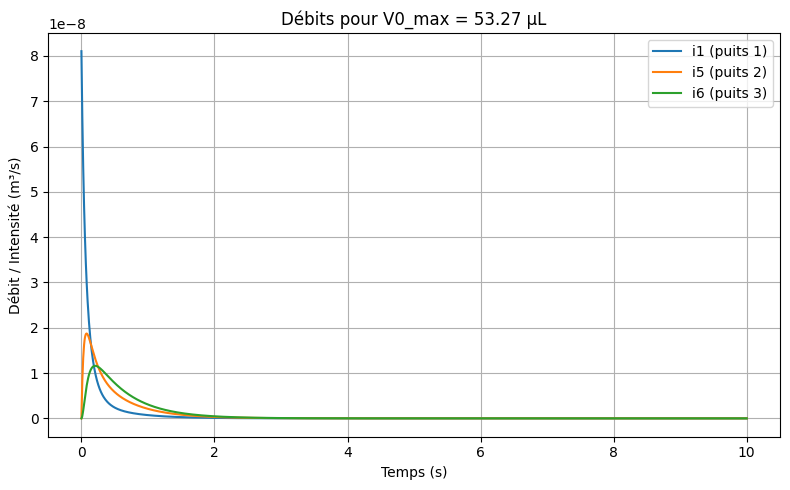

In [322]:
# Calcul du coefficient de proportionnalité
V_test = 1e-9  # 1 µL
V1_test, V5_test, V6_test, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V_test)

# Chaque volume écoulé est proportionnel à V0 → V_i = k_i * V0
k1, k5, k6 = V1_test / V_test, V5_test / V_test, V6_test / V_test
V0_max = min(Vmax / k1, Vmax / k5, Vmax / k6)

# Résultats et tracé
print("\n--- PARAMÈTRES ---")
print(f"L1={L1*1e3:.2f} mm, L2={L2*1e3:.2f} mm, L4={L4*1e3:.2f} mm")
print(f"Vmax autorisé par trou = {Vmax*1e9:.3f} µL")
print(f"\nCoefficients k_i (V_i = k_i * V0) :")
print(f"Trou 1 : k1={k1:.3f},  Trou 2 : k5={k5:.3f},  Trou 3 : k6={k6:.3f}")
print(f"\n=> Volume injecté maximal V0_max = {V0_max*1e9:.3f} µL")

# Vérification : recalcul avec V0_max
V1, V5, V6, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V0_max)

print("\n--- VOLUMES ÉCOULÉS POUR V0_max ---")
print(f"Trou Raman 1 : {V1*1e9:.4f} µL")
print(f"Trou Raman 2 : {V5*1e9:.4f} µL")
print(f"Trou Raman 3 : {V6*1e9:.4f} µL")

# Tracé des débits
plt.figure(figsize=(8,5));
plt.plot(t, i1, label="i1 (puits 1)");
plt.plot(t, i5, label="i5 (puits 2)");
plt.plot(t, i6, label="i6 (puits 3)");
plt.xlabel("Temps (s)");
plt.ylabel("Débit / Intensité (m³/s)");
plt.title(f"Débits pour V0_max = {V0_max*1e9:.2f} µL");
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.show();

In [323]:
# Pourcentage du volume remplacé pour chaque manipulation de changement de milieu
pourcentage_remplaced_lift = [10]
for manip in range(3):
    equilibre_post_manip = (100*V0_max + pourcentage_remplaced_lift[manip]*(V_tot-V0_max))/V_tot
    pourcentage_remplaced_lift.append(equilibre_post_manip)
print(f"Pourcentage du volume remplacé = {pourcentage_remplaced_lift[3]:.2f}%")
print(f"Évolution du changement de milieu : {pourcentage_remplaced_lift}")
if pourcentage_remplaced_lift[3] > 95.5:
    print("Changement de milieu réussi")
else:
    print("Changement de milieu inadéquat")

Pourcentage du volume remplacé = 98.87%
Évolution du changement de milieu : [10, np.float64(79.06491910367073), np.float64(95.13024875404611), np.float64(98.86723737467729)]
Changement de milieu réussi


# V_max selon le débit de lift (Q_lift)

In [324]:
rho_tissus = 1020 # Densité des tissus (kg/m^3) SOURCE À CONFIRMER
rho_milieu = 1000 # Densité du milieu (kg/m^3)

In [325]:
def Q_lift(rho_tissus, rho_milieu, w_puits, d_bille):
    """ Basé sur l'équation (3-13) du mémoire de Nassim """
    current_q_lift = np.sqrt(d_bille)*w_puits**2 * np.sqrt(4/3*9.81*(rho_tissus/rho_milieu - 1));
    return current_q_lift

In [326]:
# Calcul de Q_lift
q_lift = Q_lift(rho_tissus, rho_milieu, L_puits, d_bille);
print(f"\nQ_lift = {q_lift*10**9} uL/s")

# Calcul des pressions sous le premier accès Raman et la résistance hydraulique du premier canal
P1 = -4*gamma*np.cos(np.deg2rad(theta_hydrophobe))/d_raman + h_puce*rho*g;
R1 = 12*eta*L1/(h_canal**3*W_canal*(1-0.63*h_canal/W_canal))
print(f"Résistance R1 (en Pa.s/m^3)= {R1:2.6f} " )
Pmax = R1*q_lift + P1;
print(f"Pmax = {Pmax:.6f} Pa")

# Calcul du volume critique
V_critique_lift = np.pi/4*d_inlet**2 * Pmax/(rho*g);
print(f"V_max = {V_critique_lift*10**9:.6f} uL")

h_max_lift = V_critique_lift/(np.pi*d_inlet**2)*4 * 1e3;
print(f"Hauteur critique de remplissage = {h_max_lift:.6f} mm")


Q_lift = 4.688662495851031 uL/s
Résistance R1 (en Pa.s/m^3)= 3160606015.289896 
Pmax = 113.796515 Pa
V_max = 76.620650 uL
Hauteur critique de remplissage = 11.600052 mm


In [327]:
# Pourcentage du volume remplacé pour chaque manipulation de changement de milieu
pourcentage_remplaced_lift = [10]
for manip in range(3):
    equilibre_post_manip = (100*V_critique_lift + pourcentage_remplaced_lift[manip]*(V_tot-V_critique_lift))/V_tot
    pourcentage_remplaced_lift.append(equilibre_post_manip)
print(f"Pourcentage du volume remplacé = {pourcentage_remplaced_lift[3]:.2f}%")
print(f"Évolution du changement de milieu : {pourcentage_remplaced_lift}")
if pourcentage_remplaced_lift[3] > 95.5:
    print("Changement de milieu réussi")
else:
    print("Changement de milieu inadéquat")

Pourcentage du volume remplacé = 100.10%
Évolution du changement de milieu : [10, np.float64(109.34687828038327), np.float64(99.02928740457445), np.float64(100.10081258305199)]
Changement de milieu réussi


# Calculs reliés au changement de milieu

In [328]:
c_0 = 11e-3 # Concentration initiale en mol/L VALEUR À CONFIRMER
q_glucose = 3.9e-17 # Consommation de glucose par cellule (mol/cell*s) (Valeur typique tirée du mémoire de Nassim)
rho_cellules = 2.8e11 # Densité cellulaire (cell/L) (Valeur typique tirée du typique de Nassim)
diffusivite_glucose = 2e-9 # Diffusivité typique du glucose dans l'eau (m^2/s) VALEUR À CONFIRMER
K_M = 4e-5 # Constante de Michaelis-Menten (mol/L) (Valeur typique tirée du typique de Nassim)
K_max = rho_cellules * q_glucose # Constante

In [329]:
# Calcul du nombre de Damköhler
tau_diff = (d_bille/2)**2 / diffusivite_glucose
tau_reac = c_0 / (q_glucose * rho_cellules)
Da = tau_diff / tau_reac
print(f"\nNombre de Damköhler : Da = {Da:.2f}")
print(f"La réaction est donc beaucoup plus {'rapide' if Da > 1 else 'lente'} que la diffusion.")
print(f"C'est donc la {'diffusion' if Da > 1 else 'réaction'} qui limite l'apport en glucose aux cellules.")
print(f"Ainsi, on peut considérer que le profil de concentration de glucose est {'quasi-statique' if Da < 1 else 'variable'}.")


Nombre de Damköhler : Da = 0.02
La réaction est donc beaucoup plus lente que la diffusion.
C'est donc la réaction qui limite l'apport en glucose aux cellules.
Ainsi, on peut considérer que le profil de concentration de glucose est quasi-statique.


## Méthode 1 : Approximation linéaire

In [330]:
V_canal_partiel = W_canal * h_canal * d_raman
V_M = V_puits + V_canal_partiel + V_raman # Volume de milieu métaboliquement disponible par puits
V_T = 4/3 * np.pi * (d_bille/2)**3 # Volume des tissus (des billes)

# Estimation du temps avant épuisement du glucose 
# Basé sur l'équation (6) du mémoire de Nassim
t = c_0 / (q_glucose * rho_cellules) * (V_M / V_T)
print(f"\nTemps avant épuisement du glucose : {t/3600:.2f} heures")


Temps avant épuisement du glucose : 123.75 heures


## Méthode 2 : Mécanisme de Michaelis-Menten


temps (numérique) : 915.03 s
temps (analytique) : 915.03 s


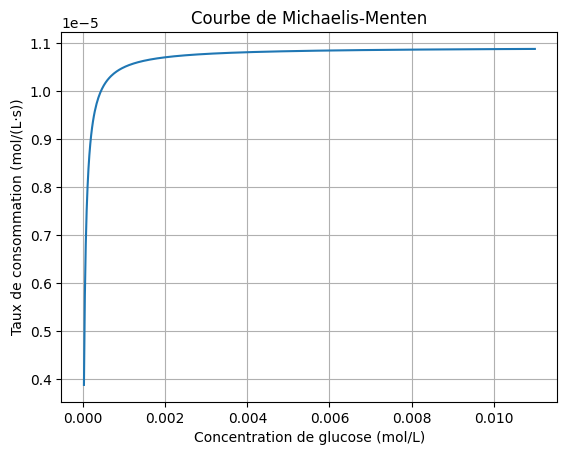

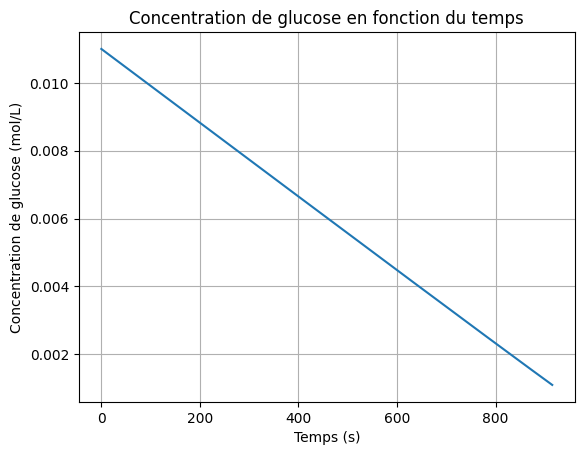

In [331]:
# Intégration numérique de c(t)
c = c_0
t = 0.0
dt = 0.01

t_list = [t]
c_list = [c]

while c > 0.1 * c_0:
    rate = K_max * c / (c + K_M)
    dc = rate * dt
    c -= dc
    t += dt
    t_list.append(t)
    c_list.append(c)

# Temps analytique (optionnel)
t_analyt = (c_0 - 0.1 * c_0 + K_M * math.log(c_0 / (0.1 * c_0))) / K_max
print(f"temps (numérique) : {t:.2f} s")
print(f"temps (analytique) : {t_analyt:.2f} s")

# Courbe rate(c)
c_vals = [i * c_0 / 500 for i in range(1, 501)]
rate_vals = [K_max * x / (x + K_M) for x in c_vals]

plt.figure()
plt.plot(c_vals, rate_vals)
plt.xlabel("Concentration de glucose (mol/L)")
plt.ylabel("Taux de consommation (mol/(L·s))")
plt.title("Courbe de Michaelis-Menten")
plt.grid(True)
plt.show()

# Courbe c(t)
plt.figure()
plt.plot(t_list, c_list)
plt.xlabel("Temps (s)")
plt.ylabel("Concentration de glucose (mol/L)")
plt.title("Concentration de glucose en fonction du temps")
plt.grid(True)
plt.show()

